In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/bike-sharing-demand/train.csv', 
                   parse_dates=['datetime'])  # datetime 컬럼을 시간 자료형으로 바꿔주기
test = pd.read_csv('/kaggle/input/bike-sharing-demand/test.csv', 
                  parse_dates=['datetime'])
sub = pd.read_csv('/kaggle/input/bike-sharing-demand/sampleSubmission.csv')

train.shape, test.shape, sub.shape

((10886, 12), (6493, 9), (6493, 2))

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')

In [4]:
new_tr = train.copy()
new_test = test.copy()

In [5]:
## 더미변수, 파생변수 생성
new_tr['year'] = new_tr['datetime'].dt.year
new_tr['month'] = new_tr['datetime'].dt.month
new_tr['day'] = new_tr['datetime'].dt.day
new_tr['hour'] = new_tr['datetime'].dt.hour
new_tr['minute'] = new_tr['datetime'].dt.minute
new_tr['second'] = new_tr['datetime'].dt.second
new_tr['dayofweek'] = new_tr['datetime'].dt.dayofweek

In [6]:
new_test['year'] = new_test['datetime'].dt.year
new_test['month'] = new_test['datetime'].dt.month
new_test['day'] = new_test['datetime'].dt.day
new_test['hour'] = new_test['datetime'].dt.hour
new_test['minute'] = new_test['datetime'].dt.minute
new_test['second'] = new_test['datetime'].dt.second
new_test['dayofweek'] = new_test['datetime'].dt.dayofweek
new_test[  ['datetime', 'year', 'month', 'day', 'hour', 'dayofweek']   ]

,datetime,year,month,day,hour,dayofweek
0,2011-01-20 00:00:00,2011,1,20,0,3
1,2011-01-20 01:00:00,2011,1,20,1,3
2,2011-01-20 02:00:00,2011,1,20,2,3
3,2011-01-20 03:00:00,2011,1,20,3,3
4,2011-01-20 04:00:00,2011,1,20,4,3
...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,2012,12,31,19,0
6489,2012-12-31 20:00:00,2012,12,31,20,0
6490,2012-12-31 21:00:00,2012,12,31,21,0
6491,2012-12-31 22:00:00,2012,12,31,22,0


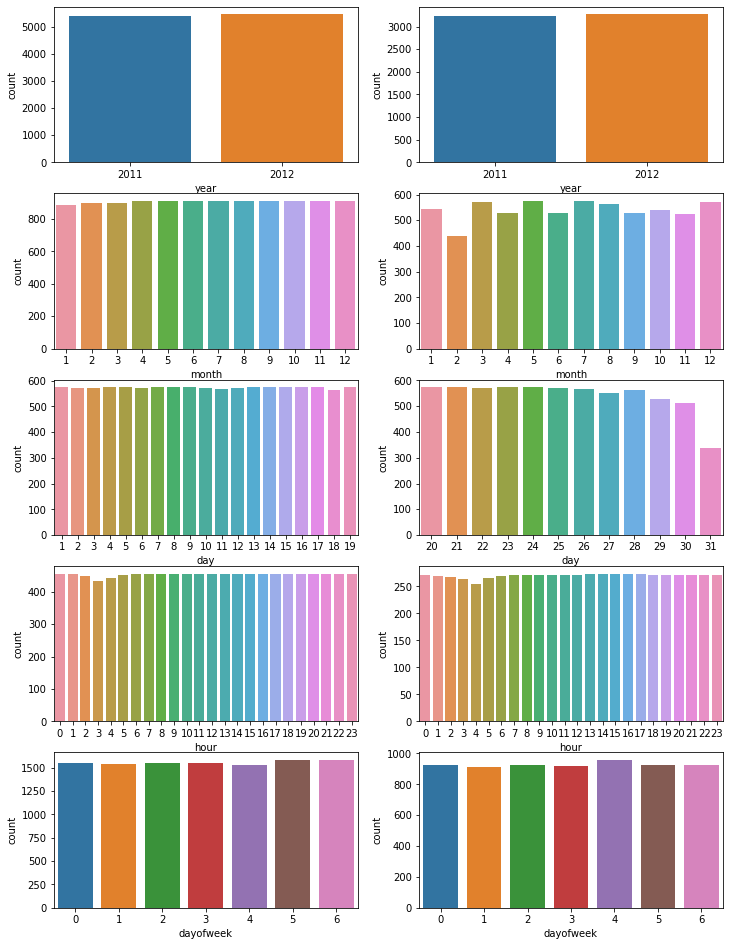

In [7]:
col_names = ['year','month','day','hour','dayofweek']
i = 0

plt.figure(figsize=(12,20))  ##전체 그래프 크기 지정

for name in col_names: ## 컬럼명으로 반복
  i = i+1
  plt.subplot(6,2,i)  ##2행2열, i = 1,2,3,4 (왼쪽 상단부터 시계방향으로 순번 지정)
  sns.countplot(name, data = new_tr)
  
  i = i+1
  plt.subplot(6,2,i)  ##2행2열, i = 1,2,3,4 (왼쪽 상단부터 시계방향으로 순번 지정)
  sns.countplot(name, data = new_test)
  
plt.show()

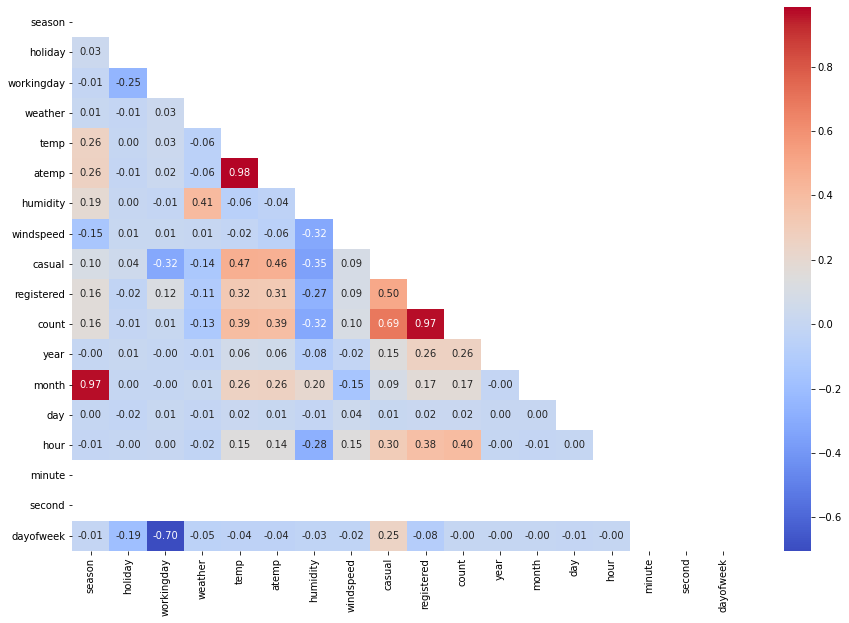

In [8]:
mask = np.zeros_like(new_tr.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(15,10))
g = sns.heatmap(new_tr.corr(), mask=mask, annot=True, fmt=".2f", cmap="coolwarm")

In [9]:
feature_names = [ 'season', 'holiday', 'workingday', 'weather', 'temp',
                  'atemp', 'humidity', 'windspeed', "year", "hour", "dayofweek"]# 공통 변수 

X_train = new_tr[feature_names]  # 학습용 데이터 변수 선택
print(X_train.head())

   season  holiday  workingday  weather  temp   atemp  humidity  windspeed  \
0       1        0           0        1  9.84  14.395        81        0.0   
1       1        0           0        1  9.02  13.635        80        0.0   
2       1        0           0        1  9.02  13.635        80        0.0   
3       1        0           0        1  9.84  14.395        75        0.0   
4       1        0           0        1  9.84  14.395        75        0.0   

   year  hour  dayofweek  
0  2011     0          5  
1  2011     1          5  
2  2011     2          5  
3  2011     3          5  
4  2011     4          5  


In [10]:
new_tr['log_count'] = np.log1p(new_tr['count'] )

In [11]:
label_name = 'log_count'                # 렌탈 대수 (종속변수)
y_train = new_tr[label_name]        # 렌탈 대수 변수 값 선택
X_test = new_test[feature_names]    # 테스트 데이터의 변수 선택 
X_test.head()                       # 테스트 데이터 선택된 내용 보기 

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek
0,1,0,1,1,10.66,11.365,56,26.0027,2011,0,3
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,3
2,1,0,1,1,10.66,13.635,56,0.0000,2011,2,3
3,1,0,1,1,10.66,12.880,56,11.0014,2011,3,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,4,3


In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
import lightgbm as lgb

import numpy as np
import time

In [13]:
model_list = ['RandomForestRegressor', 'xgb_basic', 
             'lightgbm_model1', 'lightgbm_model2']
model_score = []
model_time = []

In [14]:
now_time = time.time()

model_RF = RandomForestRegressor(random_state=30)
model_RF.fit(X_train, y_train)
score = cross_val_score(model_RF, X_train, y_train, 
                        cv=5, scoring="neg_mean_squared_error")
m_score = np.abs(score.mean())  # 절대값
model_score.append(m_score)

pro_time = round(time.time() - now_time, 2)
model_time.append(pro_time)

print(pro_time, '[sec]')  # 걸린 시간
print("RandomForestRegressor Score : {}".format(m_score))  # 점수

19.35 [sec]
RandomForestRegressor Score : 0.23269844834539466


In [15]:
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

In [16]:
now_time = time.time()

xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
            colsample_bytree = 0.3, # 각나무마다 사용하는 feature 비율
            learning_rate = 0.1,
            max_depth = 3, 
            alpha = 0.1, 
            n_estimators = 100)  # n_estimators=100

xg_reg.fit(X_train, y_train)
score = cross_val_score(xg_reg, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
m_score = np.abs(score.mean())  # 절대값
model_score.append(m_score)

pro_time = round(time.time() - now_time, 2)
model_time.append(pro_time)

print(pro_time, '[sec]')  # 걸린 시간
print("Xgboost Score : {}".format(m_score))  # 점수

[04:04:41] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[04:04:41] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[04:04:41] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[04:04:42] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[04:04:42] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[04:04:42] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
0.8 [sec]
Xgboost Score : 0.30084686102127745


In [17]:
now_time = time.time()

m_lgbm1 = lgb.LGBMRegressor()
m_lgbm1.fit(X_train, y_train)
score = cross_val_score(m_lgbm1, X_train, y_train, 
                        cv=5, scoring="neg_mean_squared_error")

m_score = np.abs(score.mean())  # 절대값
model_score.append(m_score)

pro_time = round(time.time() - now_time, 2)
model_time.append(pro_time)

print(pro_time, '[sec]')  # 걸린 시간
print("LightGBM Score : {}".format(m_score))  # 점수

0.77 [sec]
LightGBM Score : 0.1835259588783745


In [18]:
hyperparameters = {'boosting_type': 'gbdt', 
                   'colsample_bytree': 0.7250136792694301, 
                   'is_unbalance': False, 
                   'learning_rate': 0.013227664889528229,
                   'min_child_samples': 20, 
                   'num_leaves': 56, 
                   'reg_alpha': 0.7543896477745794, 
                   'reg_lambda': 0.07152751159655985, 
                   'subsample_for_bin': 240000, 
                   'subsample': 0.5233384321711397, 
                   'n_estimators': 1093}

In [19]:
now_time = time.time()

m_lgbm2 = lgb.LGBMRegressor(**hyperparameters)
m_lgbm2.fit(X_train, y_train)
score = cross_val_score(m_lgbm2, X_train, y_train, 
                        cv=5, scoring="neg_mean_squared_error")

m_score = np.abs(score.mean())  # 절대값
model_score.append(m_score)

pro_time = round(time.time() - now_time, 2)
model_time.append(pro_time)

print(pro_time, '[sec]')  # 걸린 시간
print("LightGBM Score : {}".format(m_score))  # 점수

12.38 [sec]
LightGBM Score : 0.17314083367257482


In [20]:
model_list, model_score, model_time

(['RandomForestRegressor', 'xgb_basic', 'lightgbm_model1', 'lightgbm_model2'],
 [0.23269844834539466,
  0.30084686102127745,
  0.1835259588783745,
  0.17314083367257482],
 [19.35, 0.8, 0.77, 12.38])

In [21]:
import pandas as pd

dat = pd.DataFrame( {'model_name':model_list, 'score': model_score, 'time': model_time})
dat

,model_name,score,time
0,RandomForestRegressor,0.232698,19.35
1,xgb_basic,0.300847,0.80
2,lightgbm_model1,0.183526,0.77
3,lightgbm_model2,0.173141,12.38


<AxesSubplot:>

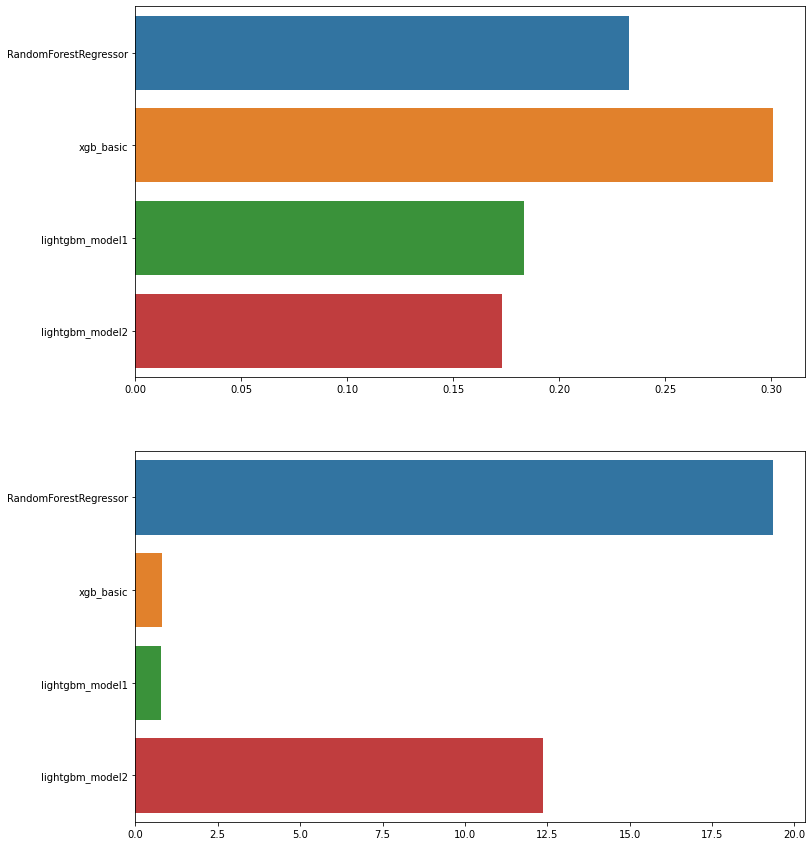

In [22]:
plt.figure(figsize=(12,15))  ##전체 그래프 크기 지정

plt.subplot(2,1,1)
sns.barplot(x=model_score , y=model_list, data=dat)

plt.subplot(2,1,2)
sns.barplot(x=model_time , y=model_list, data=dat)